In [1]:
# INICIANDO

import time
ini=time.time()

import numpy as np
import pandas as pd
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

imp_fert=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/imp_fert_ncm_quanti.csv')
exp_soja=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer/DB/temp/exp_soja_ncm_quanti.csv')

comex=pd.concat([imp_fert,exp_soja]).sort_values(by=['year','month'])\
.drop(columns=['US$_freight','US$_insurance','cif_kg','fob_kg','preço'])

imp_fert=exp_soja=0

# filtra km deixando passar o maior km de cada produto
filtra_km=comex[['Product','km']].drop_duplicates().sort_values(by=['Product','km'],ascending=False)\
    .drop_duplicates(subset='Product')
comex=comex.merge(filtra_km)
comex=comex.rename(columns={'US$_fob':'fob'})

# Save real begins and ends
comex['date']=pd.to_datetime(comex.year.astype(str)+'-'+comex.month.astype(str)+'-01')

In [2]:
# PARAMETROS


cat_cols=['month','Product','UF']

# hipotesys to test
hip_list = ['lonely','conj']

# General 
years_rept=10
prdt_foco='MOP'
uf_foco='BA'
qtt_foco=['kg','fob']
month_foco=[(comex.date.max()+DateOffset(months=1)).month]
train_max=10 # lenght
train_min=10 # lenght

            

# Parameters for lonely processing
prdt_lonely=[prdt_foco]
uf_lonely=[uf_foco]

month_lonely=month_foco
degree=1

# Parameters for joint processing
prdt_conj=[prdt_foco]+['MAP','Soy Group']
uf_conj=[uf_foco]+['GO','MT','TO']
m_ext=3
m_ini=month_foco[0]-m_ext
month_conj=np.arange(m_ini,month_foco[0]+1)
month_conj[month_conj<=0]+=12
max_depth=7
max_features=None

# Dict for tests
dict={'lonely':[prdt_lonely, uf_lonely, month_lonely],
      'conj'  :[prdt_conj  , uf_conj,   month_conj]}

In [3]:
# MODELS

# Classfication
from sklearn.ensemble import RandomForestClassifier as rfc
model_rfc=rfc(max_depth=max_depth,max_features=max_features)

# Regression

# RFR
from sklearn.ensemble import RandomForestRegressor as rfr
model_rfr=rfr(max_depth=max_depth,max_features=max_features)

# Polynomial Linear
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
polynomial_features = PolynomialFeatures(degree=degree)
linear_regression = LinearRegression()
model_plr = make_pipeline(polynomial_features, linear_regression)

In [4]:
# PREPROCESSING


comex=comex.groupby(by=['year']+cat_cols
                   )[['kg','fob']].sum().reset_index()

# Save real begins and ends
comex['date']=pd.to_datetime(comex.year.astype(str)+'-'+comex.month.astype(str)+'-01')
date_min=comex.date.min()
date_max=comex.date.max()

# Calendar full
years=pd.DataFrame({'year':np.arange(date_min.year, date_max.year+1)}).assign(key=0)
months=pd.DataFrame({'month':np.arange(1,13)}).assign(key=0)
calendar=years.merge(months,on='key')


cat=comex[[x for x in cat_cols if x not in ['month']]].drop_duplicates().assign(key=0)
comex_cal_cat=calendar.merge(cat,on='key').drop('key',axis=1)

comex_sprs=comex_cal_cat.merge(comex,how='outer').fillna(0)

# Prune
comex_sprs['date']=pd.to_datetime(comex_sprs.year.astype(str)+'-'+comex_sprs.month.astype(str)+'-01')
comex_sprs=comex_sprs[(comex_sprs.date>=date_min)&(comex_sprs.date<=date_max)]

# Indentify occurances
comex_sprs=comex_sprs.assign(oc=0)
comex_sprs.loc[comex_sprs.kg>0,'oc']=1

h=dict['conj']

# Filtra conforme o teste a ser feito
comex_sprs_hip=comex_sprs[
(comex_sprs.Product.isin(h[0]))&
(comex_sprs.UF.isin(h[1]))&
(comex_sprs.month.astype(int).isin(h[2]))].copy()

In [5]:
%run 'pred_next_month.py'

pred_next_month_df = pred_next_month(model_c,model_r, comex_s_d, prdt_foco, uf_foco, month_foco)


In [6]:
comex_sprs_hip_t=comex_sprs_hip.copy()
q=pd.DataFrame()
for rept in range(years_rept):
    q=pd.concat([q,pred_next_month(model_rfc,model_rfr, comex_sprs_hip_t, prdt_foco, uf_foco)])
    comex_sprs_hip_t=comex_sprs_hip_t[comex_sprs_hip_t.date<=comex_sprs_hip_t.date.max()-DateOffset(years=1)]

In [7]:
comex_sprs.month=comex_sprs.month.astype(str)

In [8]:
test_pred=q.merge(comex_sprs,how='outer').dropna(subset='oc_pred')

In [9]:
test_pred

,year,date,oc_pred,kg_pred,fob_pred,Product,month,UF,kg,fob,oc
99046,2015,2015-09-01,1.0,3.822862e+07,1.358715e+07,MOP,9,BA,8.410621e+07,26473450.0,1.0
104350,2016,2016-09-01,1.0,4.676227e+07,1.402802e+07,MOP,9,BA,2.483312e+07,5028028.0,1.0
109654,2017,2017-09-01,1.0,5.075177e+07,1.428197e+07,MOP,9,BA,5.232994e+07,13731565.0,1.0
114958,2018,2018-09-01,1.0,7.448426e+07,2.096373e+07,MOP,9,BA,1.180357e+08,35175911.0,1.0
120262,2019,2019-09-01,1.0,5.156739e+07,1.614484e+07,MOP,9,BA,2.760000e+07,9221520.0,1.0
125566,2020,2020-09-01,1.0,4.732496e+07,1.275041e+07,MOP,9,BA,5.204514e+07,10851818.0,1.0
130870,2021,2021-09-01,1.0,5.252909e+07,1.500615e+07,MOP,9,BA,4.308353e+07,15245763.0,1.0
136174,2022,2022-09-01,1.0,5.967234e+07,2.954875e+07,MOP,9,BA,5.513365e+07,32555121.0,1.0
141478,2023,2023-09-01,1.0,5.798482e+07,2.728229e+07,MOP,9,BA,7.377500e+07,26883059.0,1.0
146744,2024,2024-09-01,1.0,6.938466e+07,2.641047e+07,MOP,9,BA,NaN,NaN,NaN


In [10]:
test_pred_r=test_pred[(test_pred.oc==1)&(test_pred.oc_pred==1)]

In [11]:
metrics.r2_score(test_pred_r.kg,test_pred_r.kg_pred)

0.20553826736135228

In [12]:
metrics.r2_score(test_pred_r.fob,test_pred_r.fob_pred)

0.46890865199256715

In [13]:
round(metrics.mean_absolute_percentage_error(test_pred_r.kg,test_pred_r.kg_pred),2)

np.float64(0.37)

In [14]:
round(metrics.mean_absolute_percentage_error(test_pred_r.fob,test_pred_r.fob_pred),2)

np.float64(0.42)

In [15]:
test_pred_l=pd.concat([
    test_pred.drop(columns=['kg_pred','fob_pred']).assign(tipo='real'),
    test_pred.drop(columns=['kg','fob']).rename(columns={'kg_pred':'kg','fob_pred':'fob'}).assign(tipo='pred')
])

In [16]:
c1=comex_sprs.merge(test_pred_l[['Product','UF','month']])
c1=c1[(c1.date<test_pred.date.min())&(c1.oc==1)].assign(tipo='real')

In [17]:
c2=pd.concat([c1,test_pred_l])

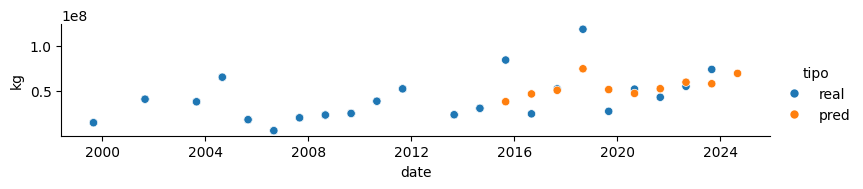

In [18]:
sns.relplot(data=c2.dropna(subset='kg'),x='date',y='kg',hue='tipo',height=2,aspect=4)